In [1]:
#importing necessary libraries:
# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#for machine learning:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5

#read csv file
full_data = pd.read_csv('hotel_bookings.csv')
full_data.head()

#print missing values
print("Nan in each columns:" , full_data.isna().sum(), sep='\n')

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Nan in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              1

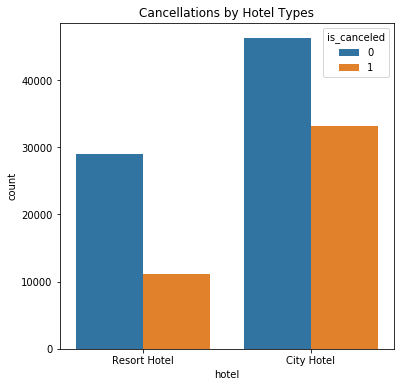

In [2]:
#------------- EDA starts from here---------
#plot to show hotel types and cancellations.
plt.figure(figsize=(6,6))
plt.title(label='Cancellations by Hotel Types')
sns.countplot(x='hotel',hue='is_canceled',data=full_data)
plt.show()

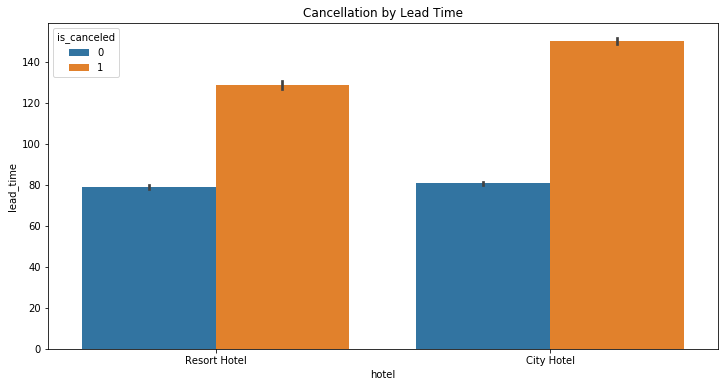

In [3]:
#plot to show cancellations by lead time
plt.figure(figsize=(12,6))
plt.title(label='Cancellation by Lead Time')
sns.barplot(x='hotel',y='lead_time',hue='is_canceled',data=full_data)
plt.show()

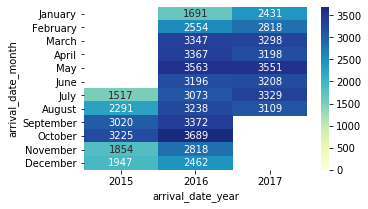

In [4]:
#plot to show peaking month by booking
bookings = full_data[full_data['is_canceled']==0].pivot_table(index='arrival_date_month', columns='arrival_date_year', values='hotel', aggfunc=len, fill_value=0)
bookings.index = pd.CategoricalIndex(bookings.index, categories=['January', 'February', 'March', 'April','May','June','July', 'August','September', 'October', 'November', 'December'], ordered=True)
bookings = bookings.sort_index()
mask = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]])
f, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(bookings, center=2000, annot=True, mask=mask, fmt="d", ax=ax, cmap="YlGnBu")
sns.set_context('paper')
plt.show()

Cancelations among new guests=  0.3778508392455442
Cancelations among old guests=  0.14488188976377953


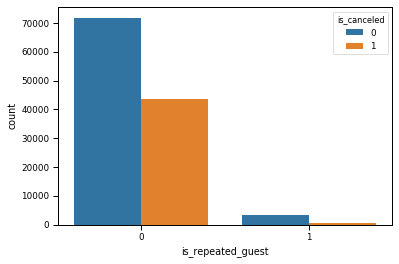

In [5]:
#plot to show effect of being old customer on cancelling. 
sns.countplot(data=full_data, x='is_repeated_guest', hue='is_canceled')
new_guest = full_data[(full_data['is_repeated_guest']==0) & (full_data['is_canceled']==1)]
old_guest = full_data[(full_data['is_repeated_guest']==1) & (full_data['is_canceled']==1)]
print('Cancelations among new guests= ', (len(new_guest))/(len(full_data[full_data['is_repeated_guest']==0])))
print('Cancelations among old guests= ', (len(old_guest))/(len(full_data[full_data['is_repeated_guest']==1])))

Transient          75.059050
Transient-Party    21.043638
Contract            3.414021
Group               0.483290
Name: customer_type, dtype: float64


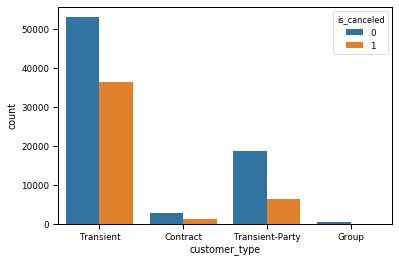

In [6]:
#customer types and plot to show them.
print(full_data['customer_type'].value_counts(normalize=True)*100)
sns.countplot(data=full_data, x='customer_type', hue='is_canceled')

In [8]:
# plot to show pie chart of countries.

import plotly.express as px
# get number of acutal guests by country
country_data = pd.DataFrame(full_data.loc[full_data["is_canceled"] == 0]["country"].value_counts())
#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [9]:
#showing meal has some undefined values.
full_data['meal'].value_counts()

BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

In [10]:
#showing there are some rows that contains zero adults zero children and babies
len(full_data[(full_data['adults']==0) & (full_data['children']==0) & (full_data['babies']==0)])

180

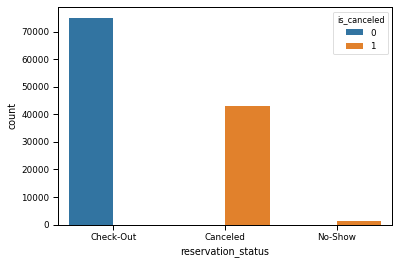

In [11]:
#showing a plot that, reservation status directly effects is_cancelled.
sns.countplot(data=full_data, x='reservation_status', hue='is_canceled')
#-------------EDA ends--------------

In [12]:
#--------DATA CLEANING PROCESS--------------
# Replacing missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# country: If non given, it should be tagged as “Unknown”.
# children: If non given, it’s probably zero.
# meal: contains values "Undefined", which is equal to SC.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)
# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# It does not make sense, so I'm dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)
#---------DATA CLEANING ENDS HERE-------------

In [13]:
#print correlation's with is_canceled column
cancel_corr = full_data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [14]:
#---------------DATA PREPROCESSING STEPS---------------

# some columns are excluded to make the model more general and to prevent leakage
# I excluded: (arrival_date_year, assigned_room_type, booking_changes, 
# reservation_status, country, days_in_waiting_list, reservation_status_date.)
# including the country would increase accuracy, but it may also make the model less general.

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data_cln.drop(["is_canceled"], axis=1)[features]
y = full_data_cln["is_canceled"]

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

#---------------DATA PREPROCESSING STEPS ENDS HERE---------------

In [15]:
#---------------DEFINING MODELS AND IMPLEMENTING-----------------

# define models to test:
base_models = [("DecisionTree", DecisionTreeClassifier(random_state=42)),
               ("RandomForest", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LogisticRegression", LogisticRegression(random_state=42,n_jobs=-1)),]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 10 # 10 = 90% train, 10% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    print(f"******** {name} ********")
    for score in ["accuracy", "precision", "recall", "f1"]:
        print(f"{score}:", end=" ")
        # pack preprocessing of data and the model in a pipeline:
        model_steps = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])    
        # get cross validation score for each model and each score metric:
        print(cross_val_score(model_steps, X, y, cv=split, scoring=score, n_jobs=-1).mean())


******** DecisionTree ********
accuracy: 0.8294606157201578
precision: 0.768783172100728
recall: 0.7723184633463431
f1: 0.7705206263076707
******** RandomForest ********
accuracy: 0.8698850767553058
precision: 0.8642623866813299
recall: 0.7700003835135587
f1: 0.8143915787871041
******** LogisticRegression ********
accuracy: 0.7953527388641893
precision: 0.7984980963038264
recall: 0.6011257561191068
f1: 0.685085296927176


In [16]:
#--------------------ENHANCED RF-------------------

#enhanced random forest model with new parameters.
rf_model_enh = RandomForestClassifier(n_estimators=160,max_features=0.4,min_samples_split=2,n_jobs=-1,random_state=0)
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
for score in ["accuracy", "precision", "recall", "f1"]:
        print(f"{score}:", end=" ")
        # pack preprocessing of data and the model in a pipeline:
        model_steps = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_model_enh)])    
        # get cross validation score for each model and each score metric:
        print(cross_val_score(model_steps, X, y, cv=split, scoring=score, n_jobs=-1).mean())

accuracy: 0.8716802281687779
precision: 0.859903329287739
recall: 0.7811246046815903
f1: 0.8186023926786202


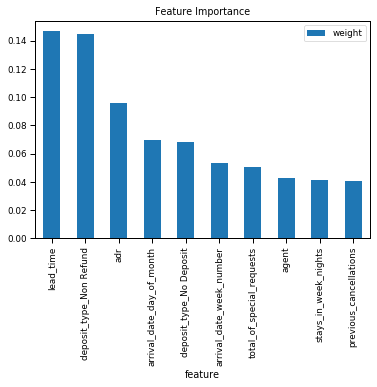

In [17]:
#-------------------Feature Importance----------------
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model_enh)])
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns
# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(model_pipe.named_steps['model'],feature_names=feat_imp_list)

#print the most important features plot.
feat_imp_df.head(10).plot(x ='feature', y='weight', kind = 'bar', title = 'Feature Importance')
plt.show()


#------END------